Detekce anomálií v EKG signálech
V EKG siglálu zaznamenáváme: 
    - P vlnu - která nastává před Q kmitem nebo R vrcholem, normální amplituda P vlny nepřesahuje 0,25 mV
    - Q kmit, První negativní kmit, který může se v komplexu nemusí vyskytovat, vyskytuje se před R vrcholem, trvání nepřesahuje 0.03s, kmit delší než 0,04s jasně poukazuje na jizvu po infarktu myokardu
    - PQ interval - od začátku P vlny do začátku komorového komplexu QRS - Fyziologické hodnoty se pohybují mezi 0,12–0,20 s.
        - Prodloužený P-Q interval znamená delší dobu převodu řídícího impulsu ze síní na komory při poruchách v A-V části převodního systému. Zkrácený PQ interval znamená, že řídící impuls se dostal na převodní systém komor dříve než normálně  protože zpravidla obešel A-V uzel abnormálními spoji převodního systému.
    - PQ úsek - doba mezi koncem P a začátkem Q
    - R vrchol - pozitivní kmit
    - S kmit - jsou negativní kmity komplexu následující za R vrcholem
    - QRS komplex - depolarizace komor(Fyziologicky QRS komplex trvá do 0,11 s.), pro výpočet se mohou použít Sokolowovy indexy
    - T vlna - 
    - QT interval - od začátku QRS komplexu po konec vlny T. Normální hodnoty jsou od 0,25 s do 0,50 s.
    - ST úsek - doba mezi koncem S a začátkem T, Odchylky od normy jsou známkou poruchy repolarizace myokardu. Typické změny ST úseku se objevují v akutní fázi transmurálního infarktu myokardu.

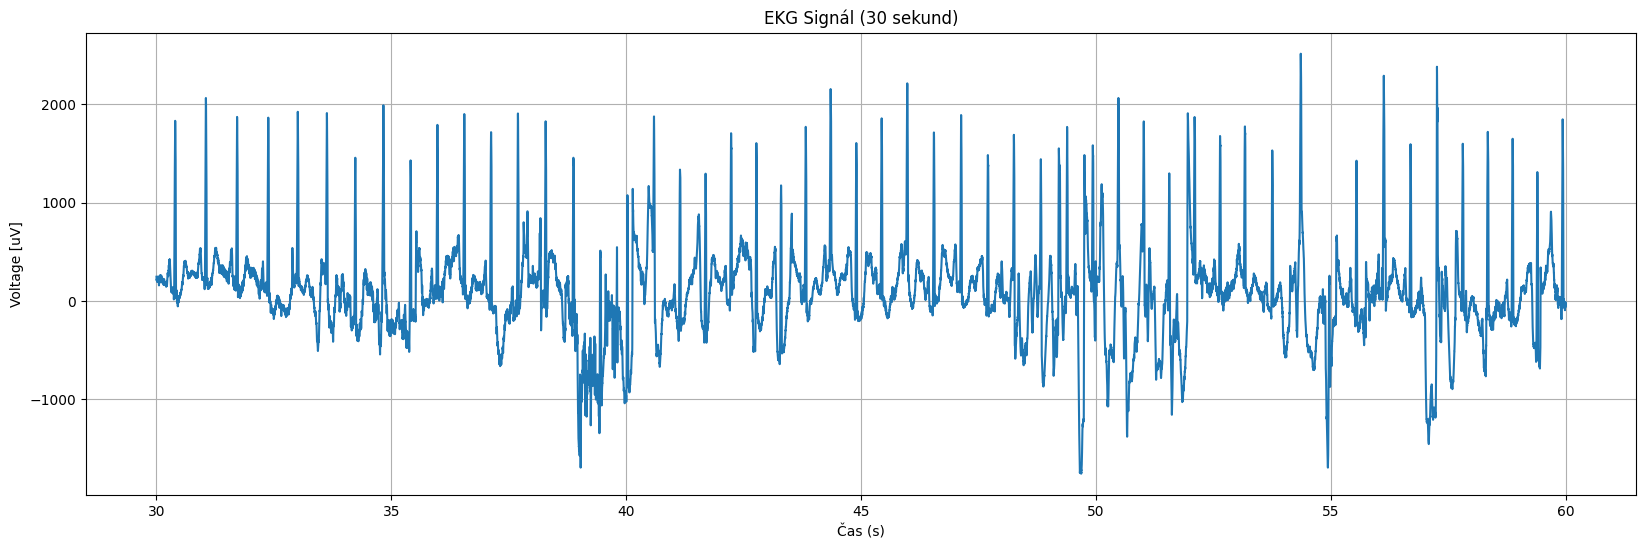

[(3007, np.float64(1912.8256513026051)), (3628, np.float64(1909.8196392785571)), (4233, np.float64(1455.9118236472946)), (4831, np.float64(1988.9779559118238)), (5409, np.float64(1426.8537074148296)), (5980, np.float64(1787.0741482965932)), (6553, np.float64(1899.799599198397)), (7123, np.float64(1715.9318637274548)), (7695, np.float64(1905.811623246493)), (8285, np.float64(1826.1523046092184)), (8875, np.float64(1455.9118236472946)), (10026, np.float64(1075.1503006012024)), (10591, np.float64(1865.2304609218436)), (11145, np.float64(1335.1703406813626)), (11690, np.float64(1294.0881763527054)), (12233, np.float64(1704.9098196392786)), (12771, np.float64(1604.2084168336673)), (13297, np.float64(1174.8496993987976)), (13822, np.float64(1768.0360721442885)), (14352, np.float64(2153.807615230461)), (14898, np.float64(1605.2104208416833)), (15438, np.float64(1848.196392785571)), (15984, np.float64(2211.9238476953906)), (16551, np.float64(1712.9258517034068)), (17130, np.float64(1889.779559

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

#detekce anomálií v signálu - způsob jak detekovat tyto úseky + prezentace statistiky výskytu úseků v měřeních
def Nacti_soubor(cesta_k_souboru): return wfdb.rdrecord(cesta_k_souboru)

ecg_mereni = Nacti_soubor(r"C:\Users\imang\OneDrive\Plocha\PZS\seminarni_prace_1\mereni_signalu\100001\100001_ECG")

ecg_signal = ecg_mereni.p_signal 
vz_f = ecg_mereni.__dict__['fs']
amplitudy = ecg_signal[:, 0]

start_time = 30
end_time = 60
start_index = int(vz_f*start_time) #vezmu si 30 sekund
end_index = int(vz_f*end_time)
ecg_signal_30_60 = amplitudy[start_index:end_index]
time_axis_30_60 = np.linspace(start_time,end_time,len(ecg_signal_30_60)) #na začátku vidím nějakou anomálii, tak si signál přesunu o 30 sekund dopředu
plt.figure(figsize=(20,6))
plt.plot(time_axis_30_60,ecg_signal_30_60) #na této ose se již dá vidět lépe srdeční tep
plt.title("EKG Signál (30 sekund)")
plt.xlabel("Čas (s)")
plt.ylabel("Voltage [uV]")
plt.grid()
plt.show()

#zase si vložím R-peaks finder
def r_peaks_finder(ecg_signal, min_peaks_height, min_distance,test=False):
    r_peaks = [] #seznam, kam si uložím souřadnice vrcholů
    for i in range(1, len(ecg_signal)-1):
        #if ekg_signal[i] > threshold and ekg_signal[i] > ekg_signal[i - 1] and ekg_signal[i] > ekg_signal[i + 1]: peaks.append(i)
        if ecg_signal[i]>min_peaks_height:
            #zkontroluji že hodnota je větší něž okolní hodnoty
            #zde jsem ještě musel přidat podmínku aby to ty vrcholi kontrolovalo o 1 navíc citlivěji, protože mi některé to vynechalo
            if ecg_signal[i]>ecg_signal[i-1] and ecg_signal[i]>ecg_signal[i+1] or ecg_signal[i]>ecg_signal[i-1] and ecg_signal[i]>ecg_signal[i+2]:
                if len(r_peaks) == 0 or (i-r_peaks[-1]>=min_distance): 
                    r_peaks.append(i)
                elif test: print(f"Vrchol ignorován (příliš blízko): Index {i}, Hodnota {ecg_signal[i]}")
            elif test: print(f"Vrchol ignorován (není lokální maximum): Index {i}, Hodnota {ecg_signal[i]}")
    #print(r_peaks[:20]) #testování
    return r_peaks

def Vypocet_prumerne_frekvence(amplitudy, dolni_mez):
    x_coords = [uV for uV in amplitudy if uV > dolni_mez] #vezmu všechny hodnoty frekvencí, které jsou delší než dolní mez frekvence
    if len(x_coords) > 0: #když měření bude obsahovat nějaké souřadnice
        prumer_x = sum(x_coords) / len(x_coords) #vypočítám si průměrnou hodnotu x vrcholů
        return prumer_x
    else: return 0

#a ted nějaký algoritmus na detekci anomálií, kam bude vstupovat ekg signál, r vrcholy a nějaké limity které se vymykají normě
def detect_anomalies_algoritm(ecg_signal,r_peaks,fs,r_peaks_max,r_peaks_min, r_to_r_max, r_to_r_min, min_P, max_P, min_T, max_T, min_QRS, max_QRS):
    # nejdřív bychom si měli určit, které anomálie můžou nastávat při ekg měření
    anomalie = {'high_amplitudes': [], 'low_amplitudes': [], "P_amp": [], "P_duration": [], "T_amp": [], "T_duration": [], "QRS_amp": [], "QRS_duration": []}
    
    # Analýza amplitud R vrcholů
    for i, amp in enumerate(r_peaks):
        if amp > r_peaks_max: anomalie["high_amplitudes"].append((amp,ecg_signal[amp]))
        elif amp < r_peaks_min: anomalie["low_amplitudes"].append((amp,ecg_signal[amp]))
    
    #detekce anomálií ve vlnách
    vlny = { "P": [], "T": [], "QRS": []}
    for r in r_peaks:
        qrs_start = max(0, r - int(0.05 * fs))  # QRS začátek
        qrs_end = min(len(ecg_signal), r + int(0.05 * fs))  # QRS konec
        vlny["QRS"].append(ecg_signal[qrs_start:qrs_end])
        
        p_start = max(0, r - int(0.2 * fs))  # P vlna začátek
        p_end = max(0, r - int(0.1 * fs))  # P vlna konec
        vlny["P"].append(ecg_signal[p_start:p_end])
        
        t_start = min(len(ecg_signal), r + int(0.1 * fs))  # T vlna začátek
        t_end = min(len(ecg_signal), r + int(0.2 * fs))  # T vlna konec
        vlny["T"].append(ecg_signal[t_start:t_end])

    #nejprve si vytvořím seznamy, kam budu ukládat vlny    
    amplitude_limits = {"P": [min_P, max_P],"T": [min_T, max_T],"QRS": [min_QRS, max_QRS]}
    #seznam pro limity délek vln v rozmezí ms
    duration_limits = {"P": [0.06*fs, 0.11*fs], "T": [0.1*fs, 0.2*fs], "QRS": [0.08*fs, 0.12*fs]} #rozmezí ms
    for wave_type, wave_intervals in vlny.items():
        for segment_value in wave_intervals:
            # Amplituda
            if any(segment_value) > amplitude_limits[wave_type][1] or any(segment_value) < amplitude_limits[wave_type][0]:
                anomalie[wave_type+"_amp"].append((segment_value,ecg_signal[segment_value]))
            # Délka trvání
            duration = len(segment_value)
            if any(segment_value) and duration < duration_limits[wave_type][0] or any(segment_value) and duration > duration_limits[wave_type][1]:
                anomalie[wave_type+"_duration"].append((segment_value,ecg_signal[segment_value]))
    
    return anomalie

dolni_mez = 500 
prumer_f = Vypocet_prumerne_frekvence(ecg_signal_30_60, dolni_mez)
min_peaks_height = prumer_f 
catching_time = 0.5
min_distance = int(vz_f*catching_time) 

r_peaks_30_60 = r_peaks_finder(ecg_signal_30_60, min_peaks_height, min_distance)

anomalie = detect_anomalies_algoritm(ecg_signal_30_60,r_peaks_30_60,vz_f,r_peaks_max=2500,r_peaks_min=500,r_to_r_max=1200,r_to_r_min=500,min_P=-500,max_P=500,min_T=-500,max_T=750,min_QRS=-2000,max_QRS=2000)
#testování
print(anomalie['high_amplitudes'],"\n",
      anomalie["low_amplitudes"],"\n",
      anomalie["P_amp"],"\n",
      anomalie["P_duration"],"\n",
      anomalie["T_amp"],"\n",
      anomalie["T_duration"],"\n",
      anomalie["QRS_amp"],"\n",
      anomalie["QRS_duration"],"\n")

